## Reinforcement Learning

Reinforcement Learning (RL) is a branch of machine learning in which the goal is for an agent (robot) to take a sequence of actions in an environment in such a way as to maximize a cumulative reward over repeated actions:

![](images/action_observation_reward.png)

The relation between actions and the environment is defined by a Policy. A policy is a rule that prescribes how the agent should act given that the environment is observed to be in a certain state. The policy may be stochastic, in which case it gives the probability of taking a certain action given a certain state. 






## Atari pong

Let's consider an example of RL. In the game of Pong, you (the agent) compete against a game simulator (the environment) by moving a paddle up and down (the actions). One can set up an environment to simulate Pong by issuing the commands

```
brew install cmake boost boost-python sdl2 swig wget
conda create -n openai python=2 ipython-notebook --yes 
source activate openai
pip install 'gym[all]' 
```




[2017-08-25 13:40:11,646] Making new env: Pong-v0



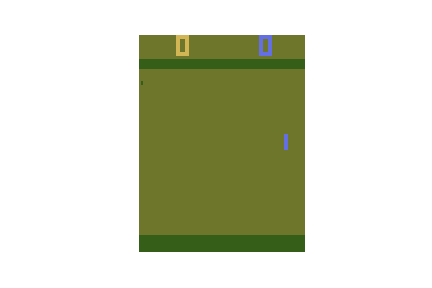
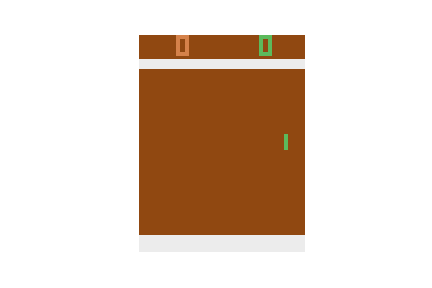
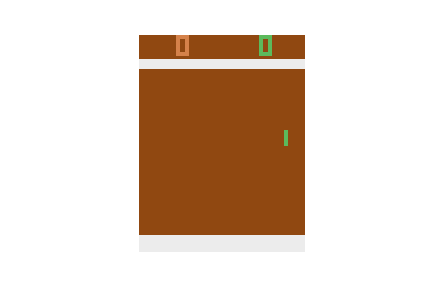
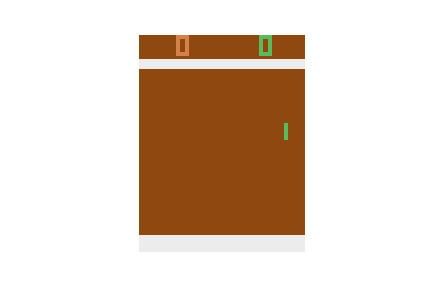
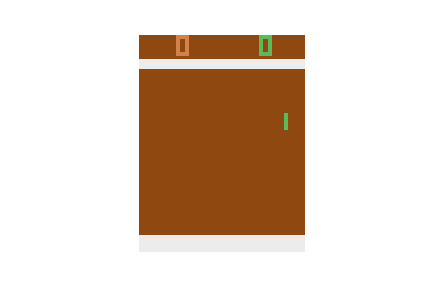
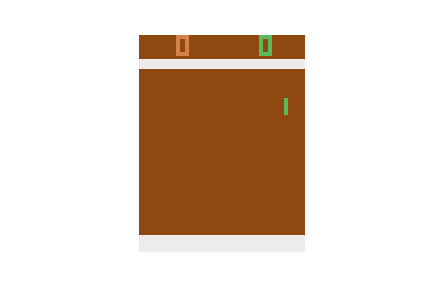
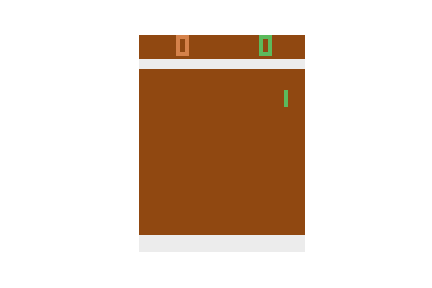
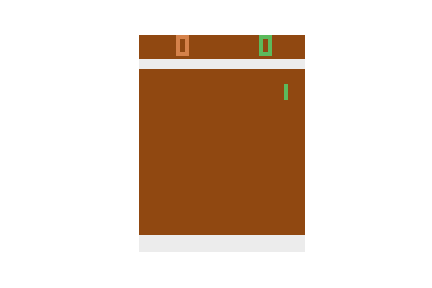
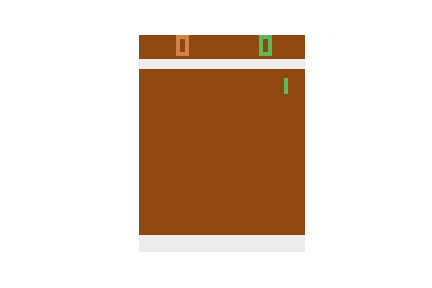
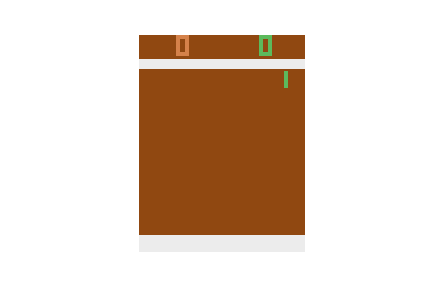
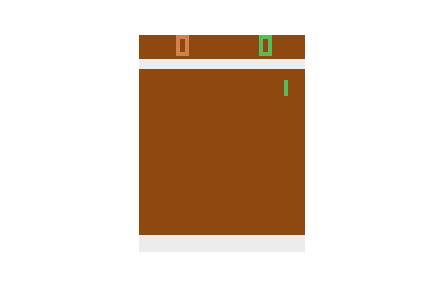
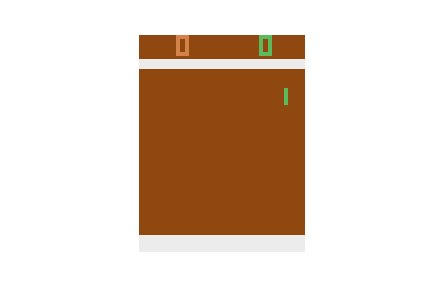
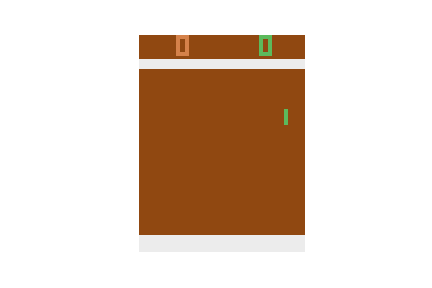
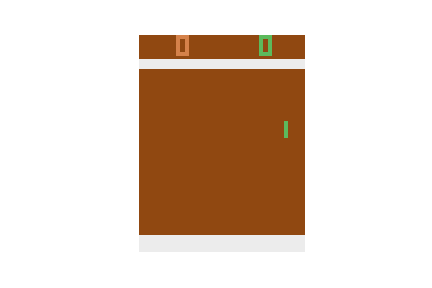
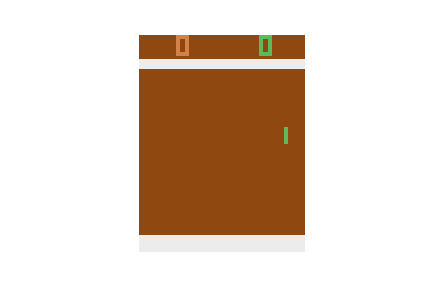
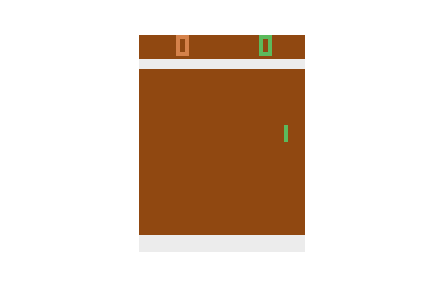
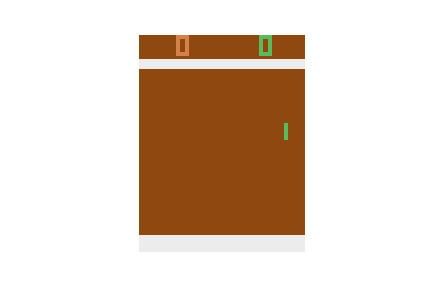
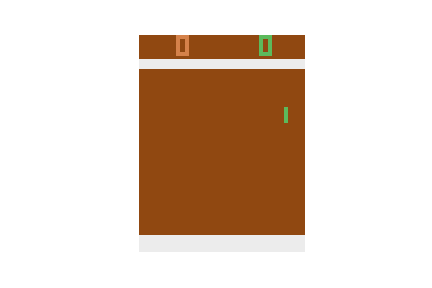
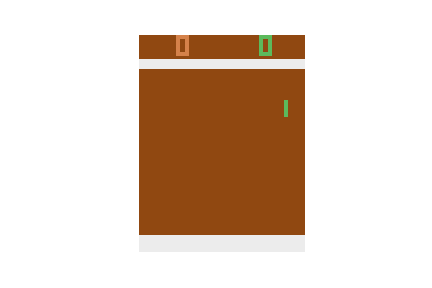
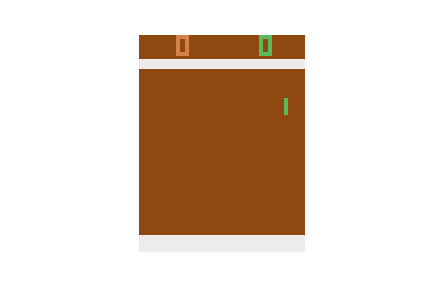
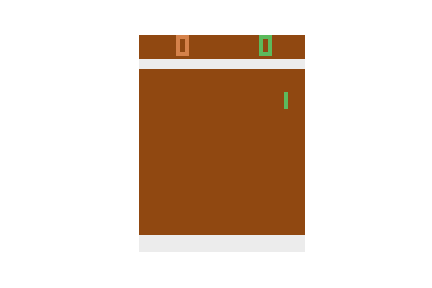
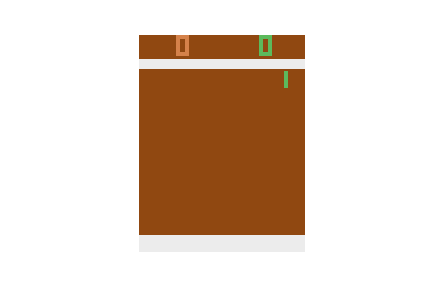
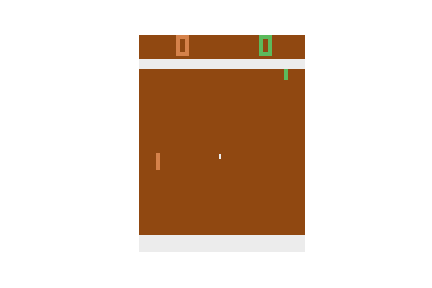
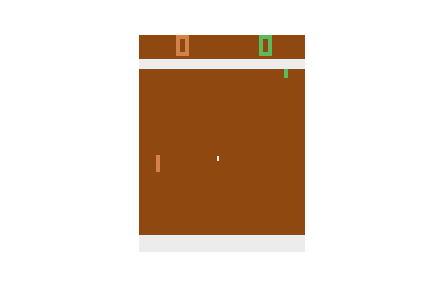
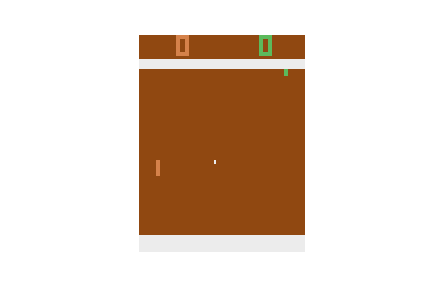
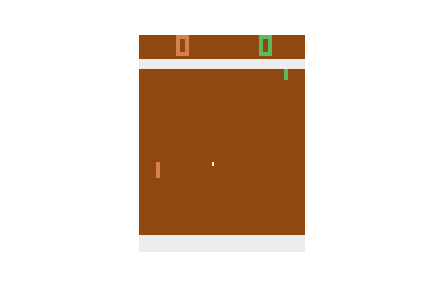
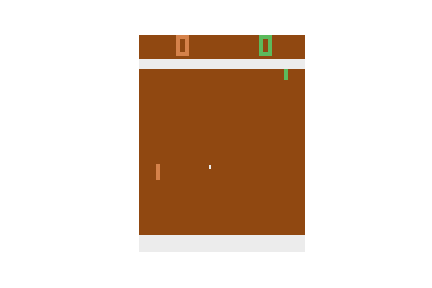
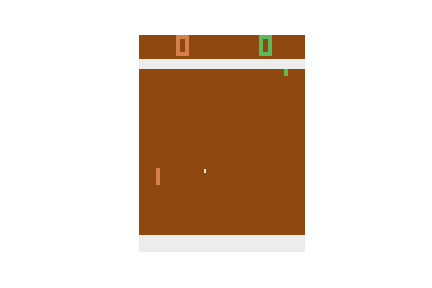
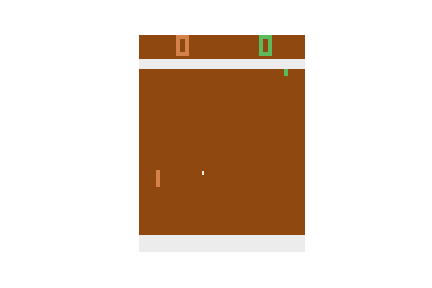
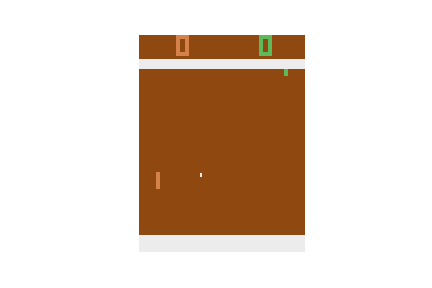
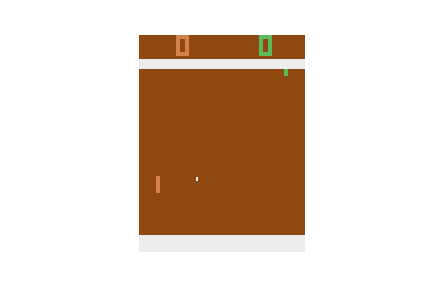
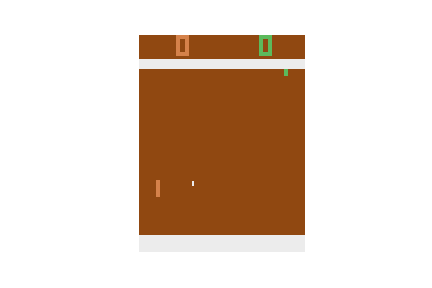
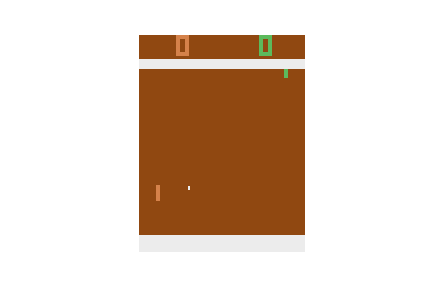
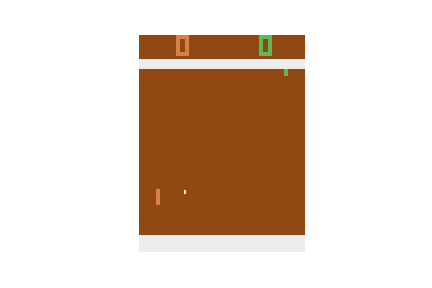
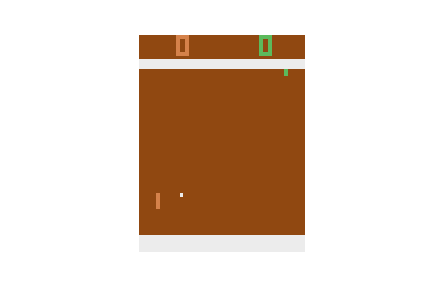
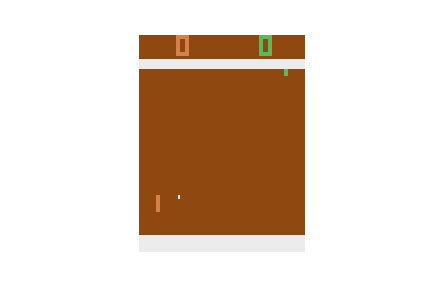
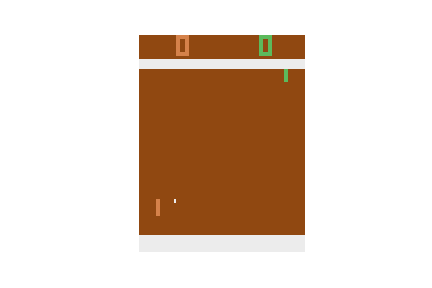
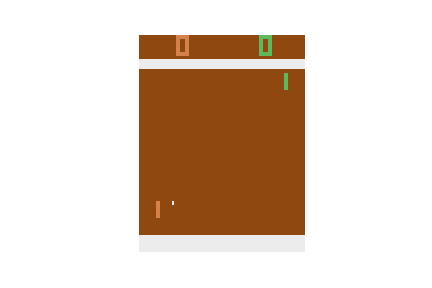
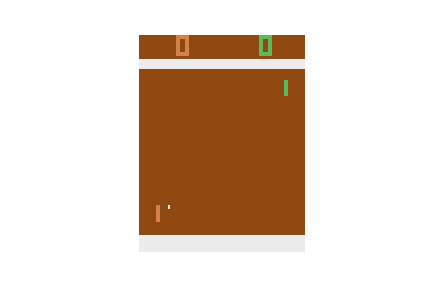
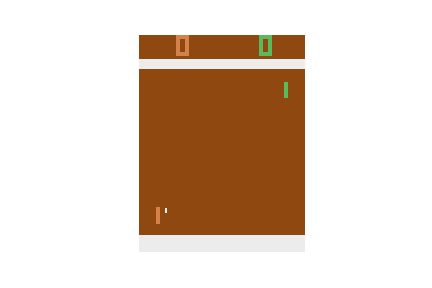
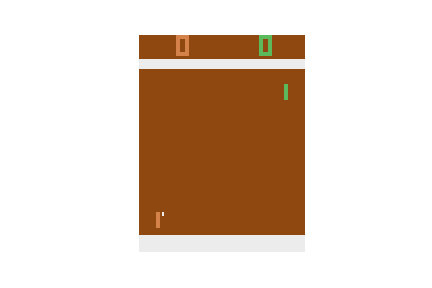
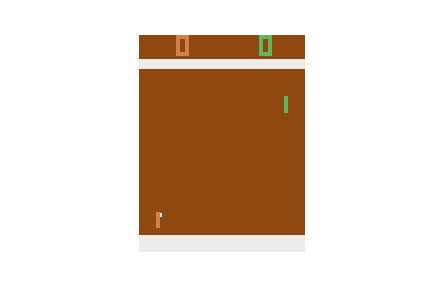
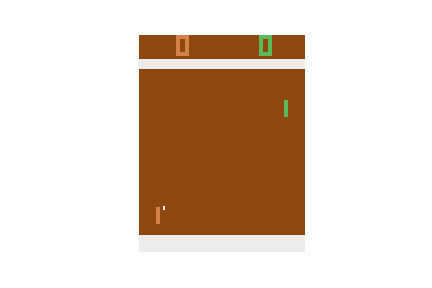
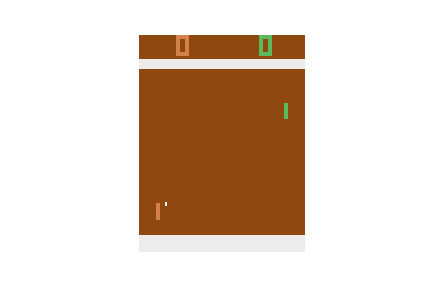
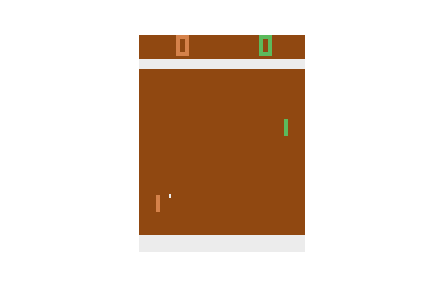
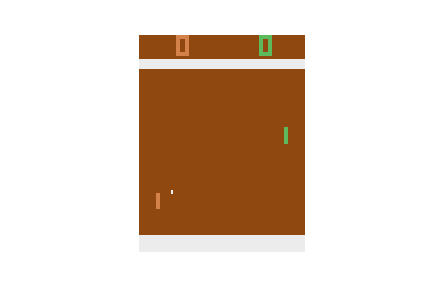
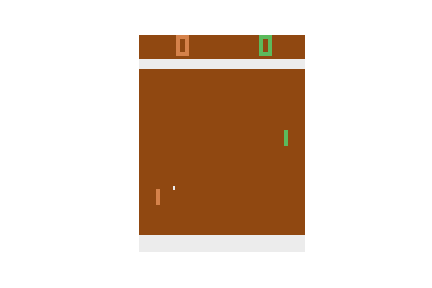
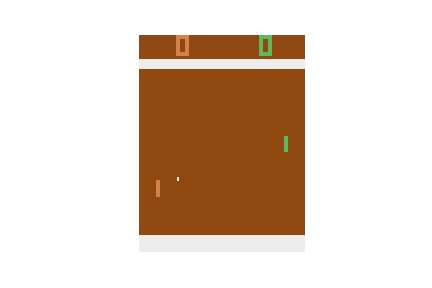
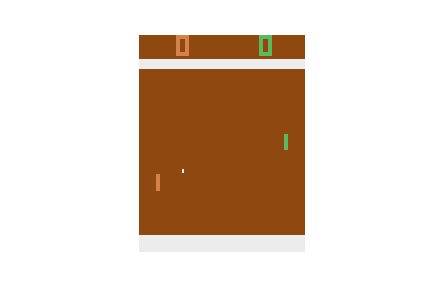
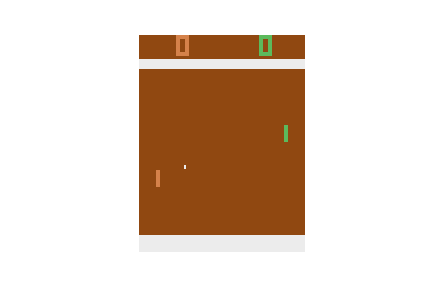
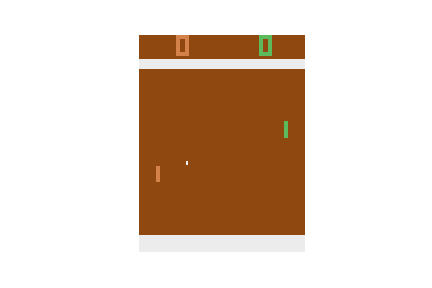
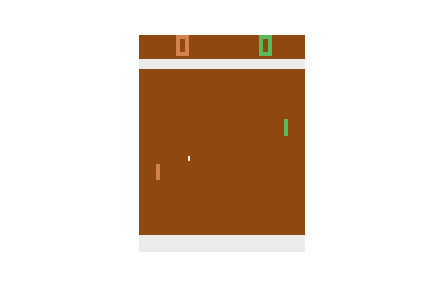
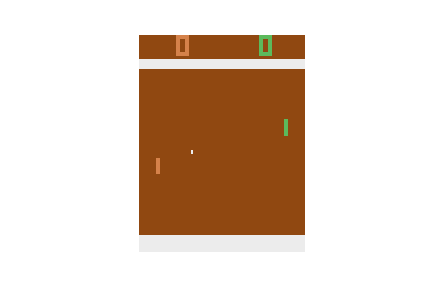
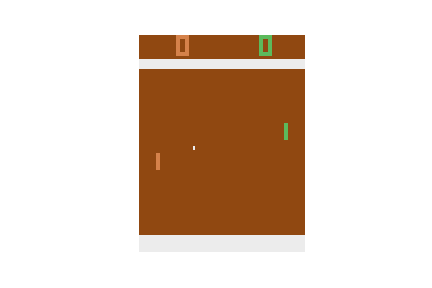
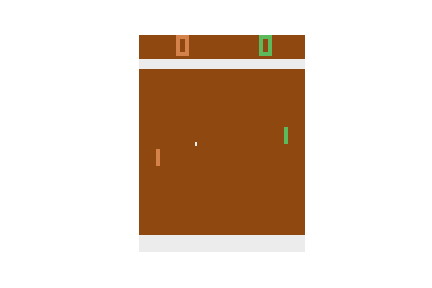
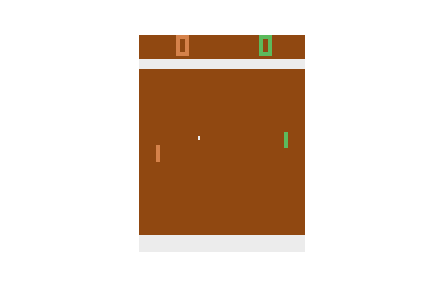
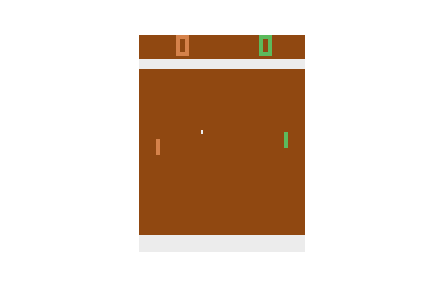
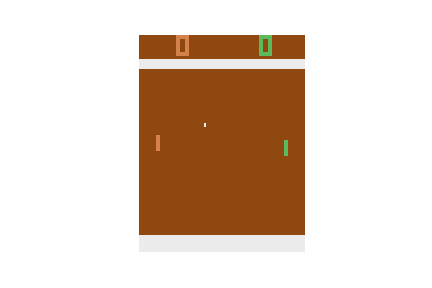
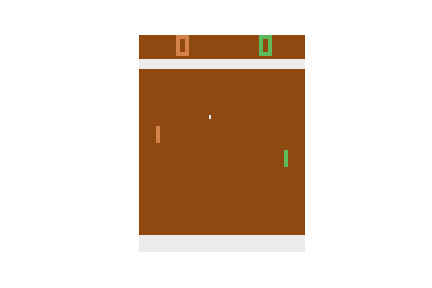
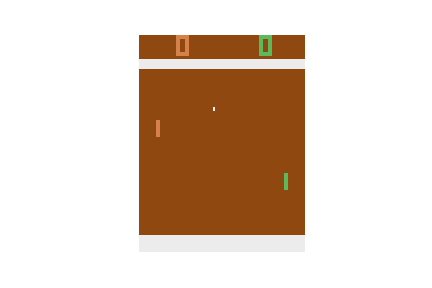
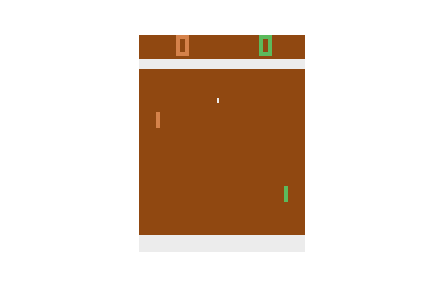
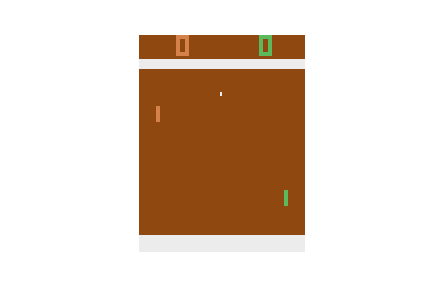
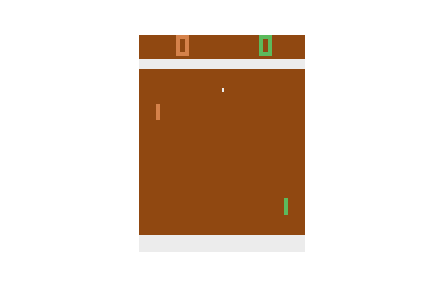
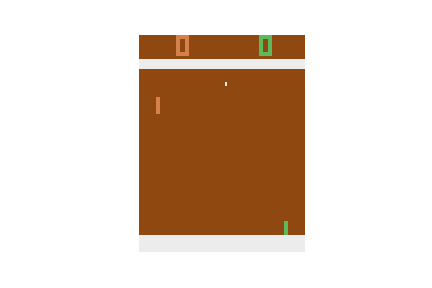
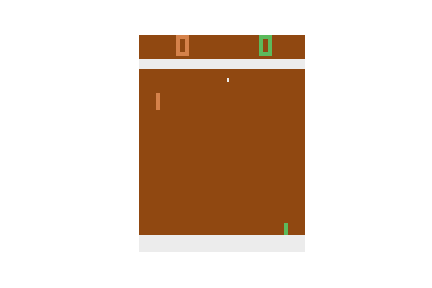
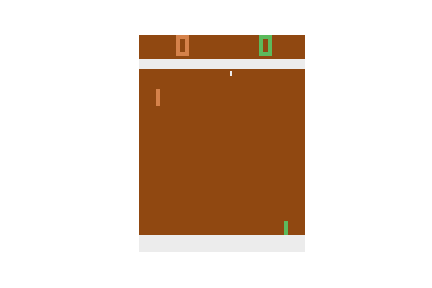
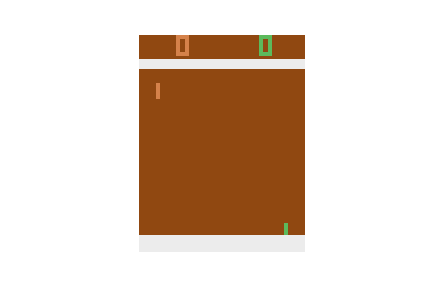
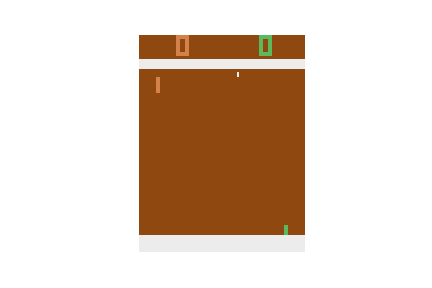
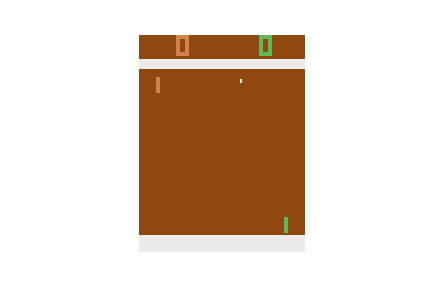
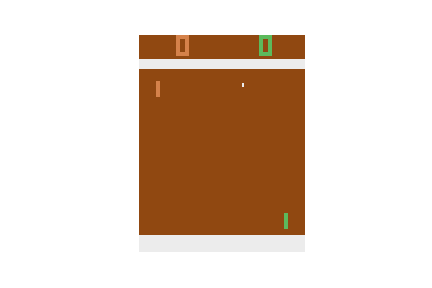
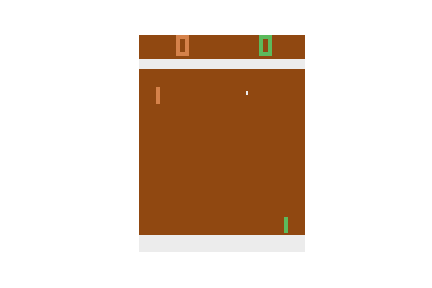
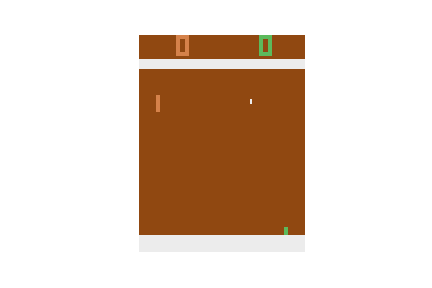
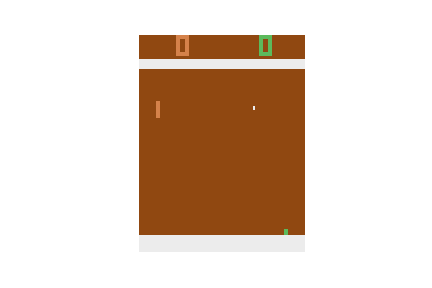
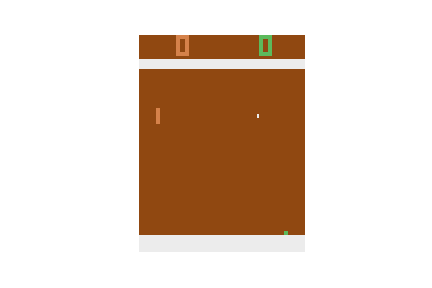
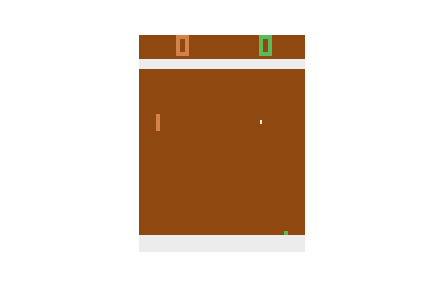
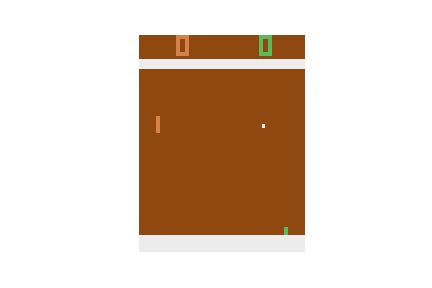
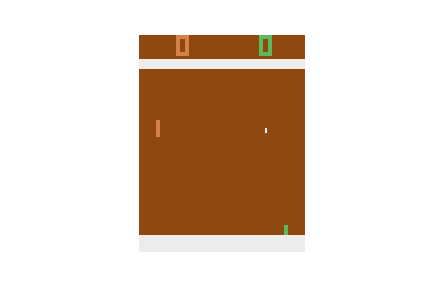
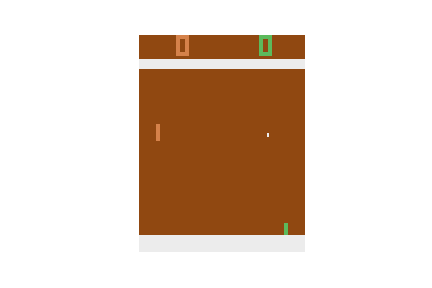
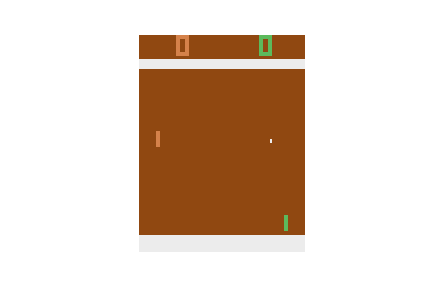
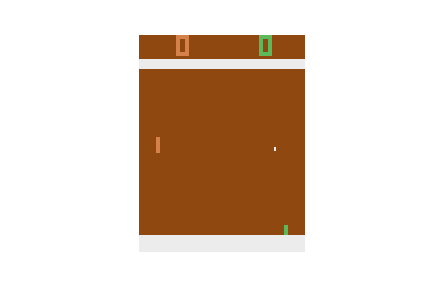
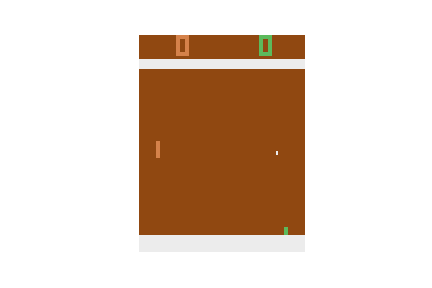
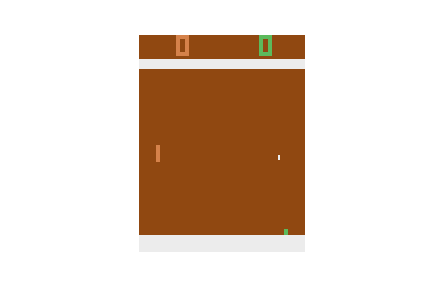
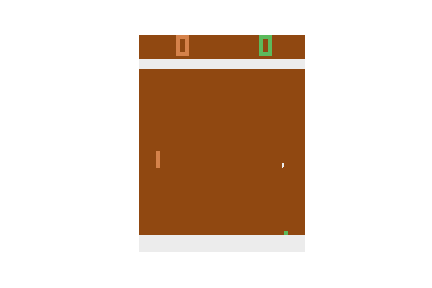
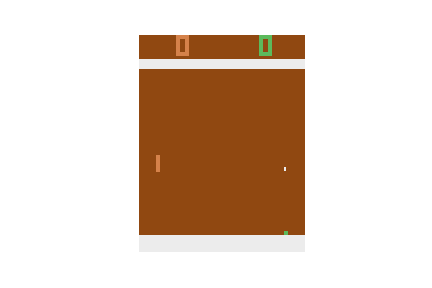
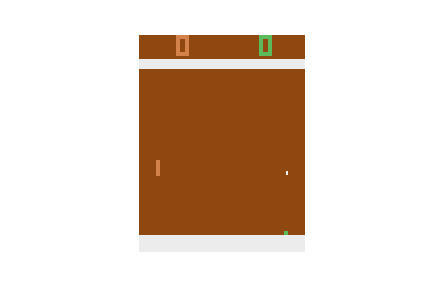
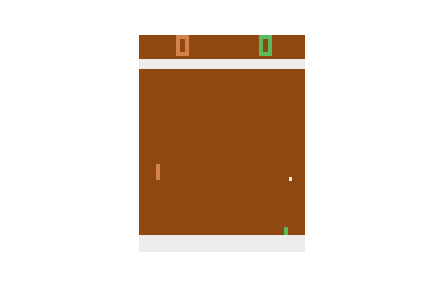
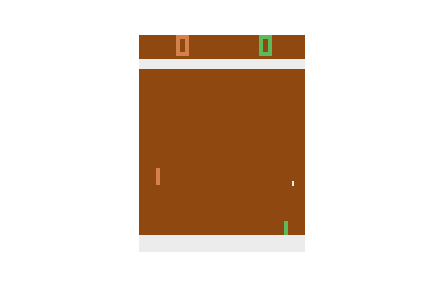
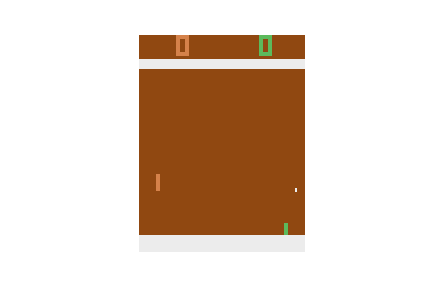
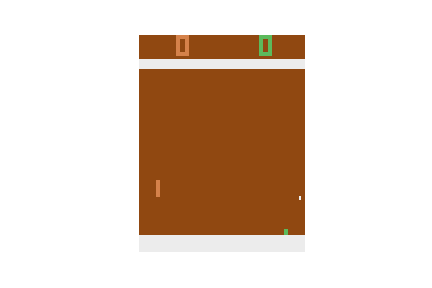
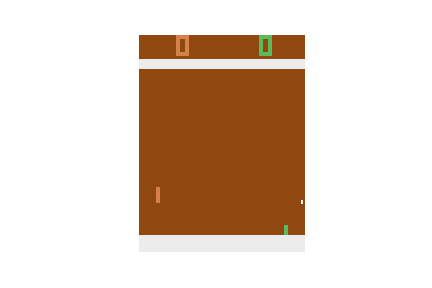
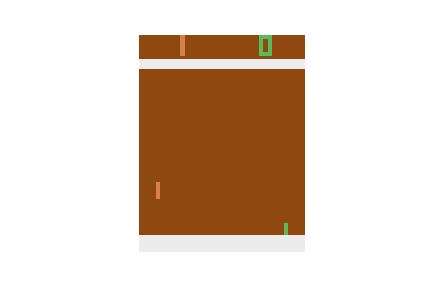
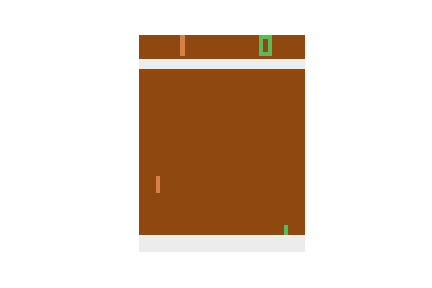
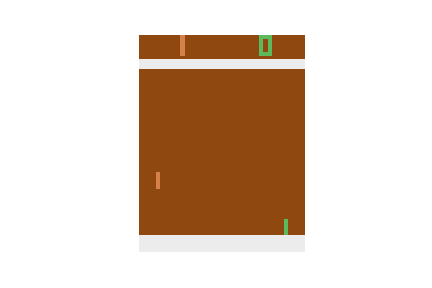
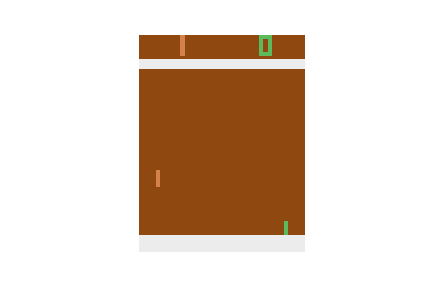
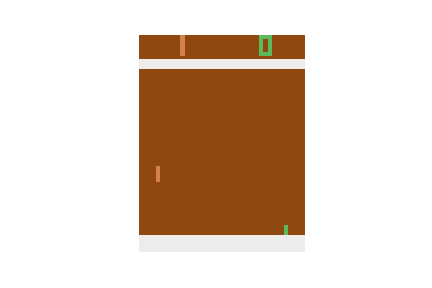
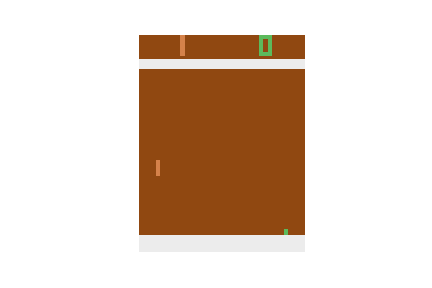
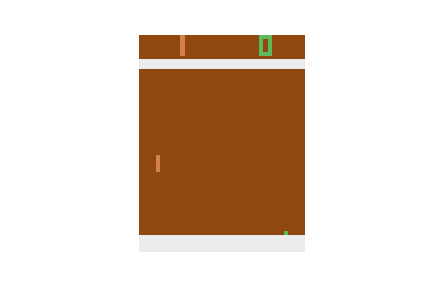
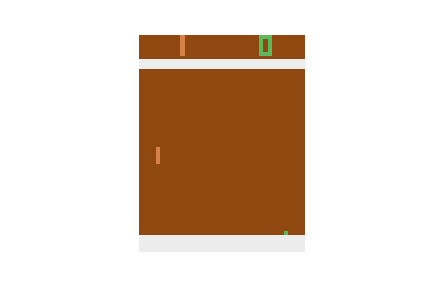
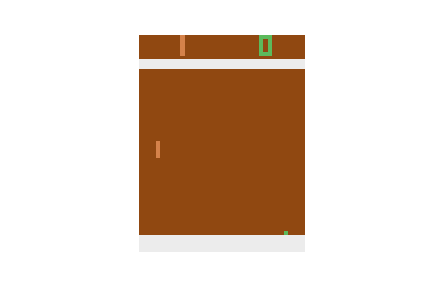
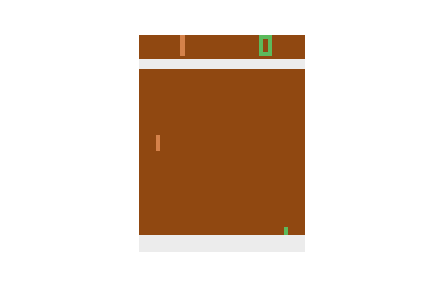
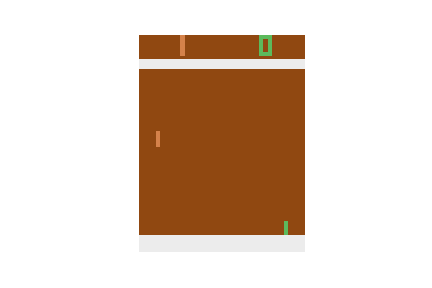
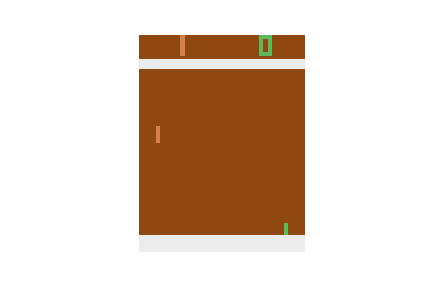
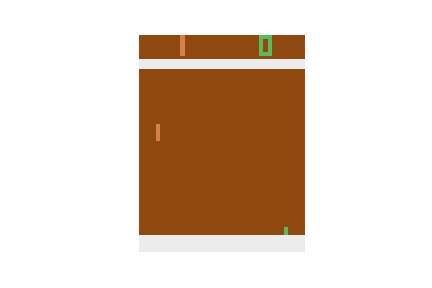
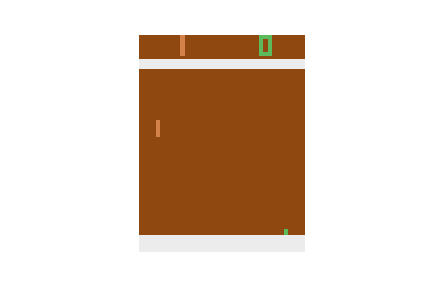
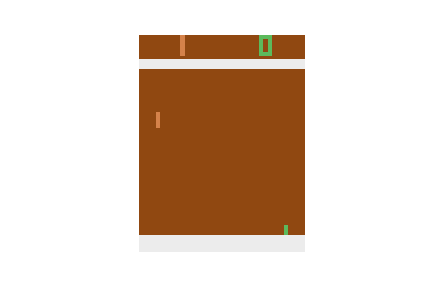
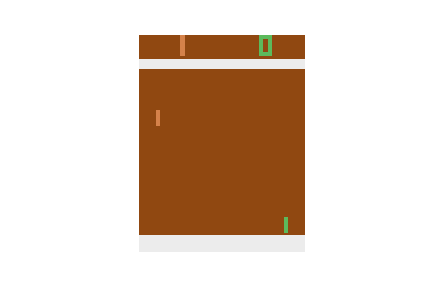
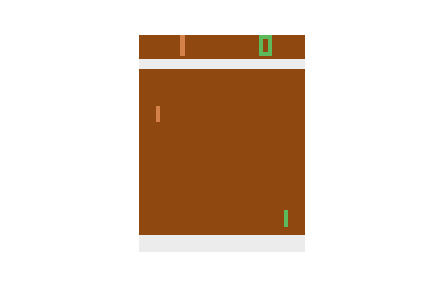
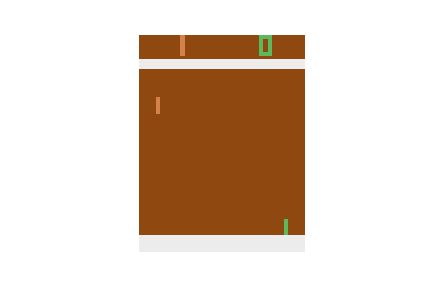
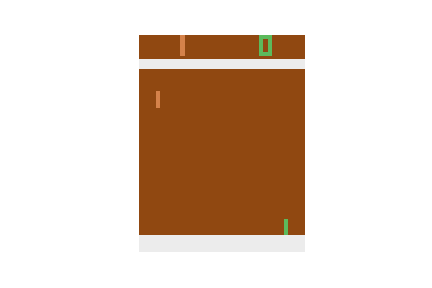
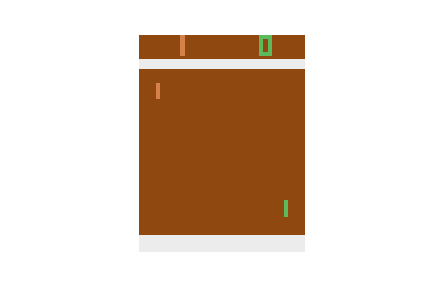
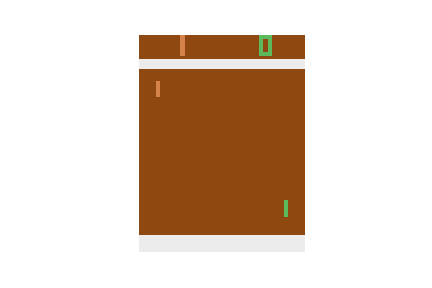
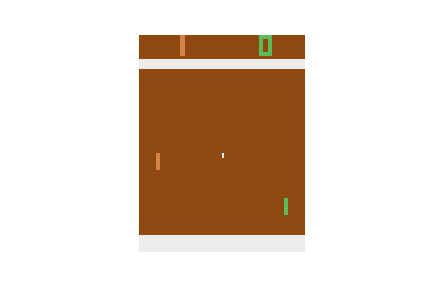
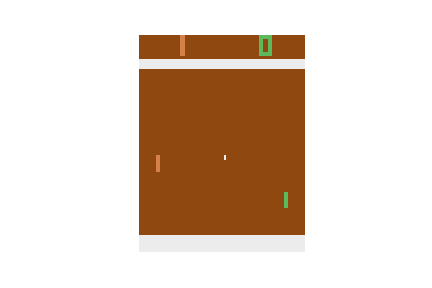
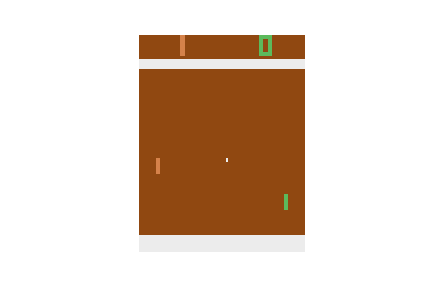
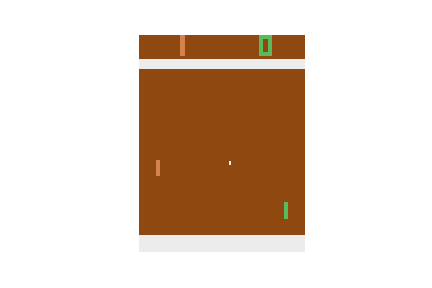
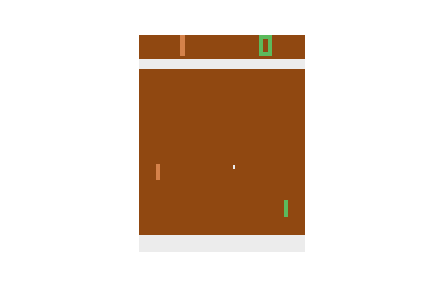
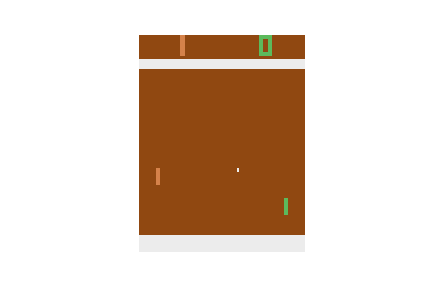
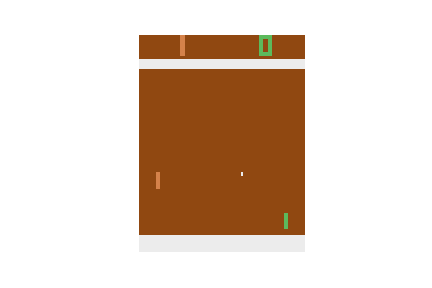
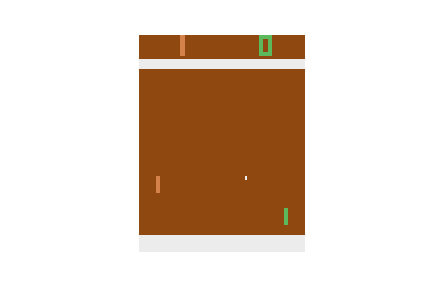
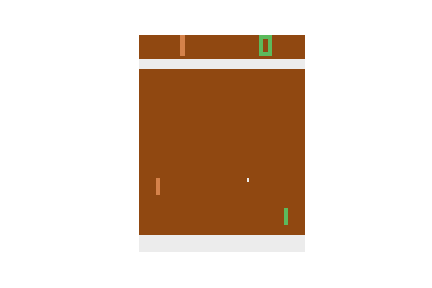
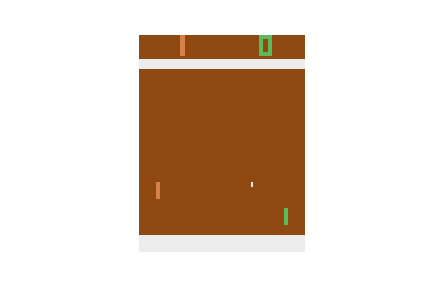
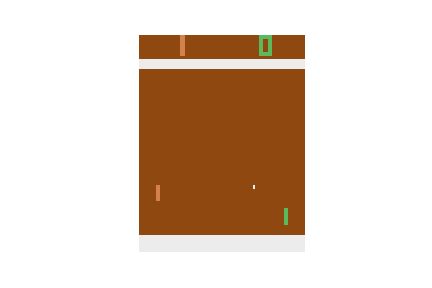
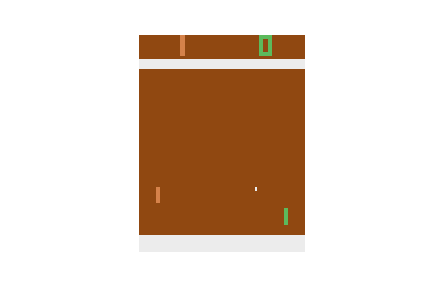
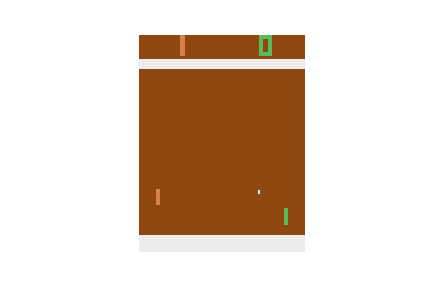
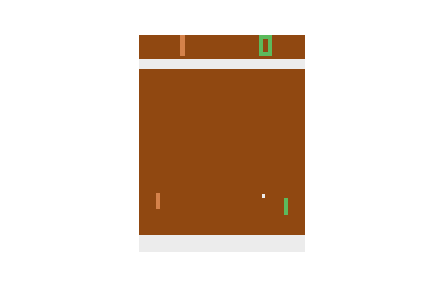
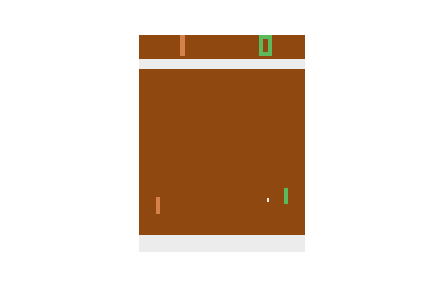
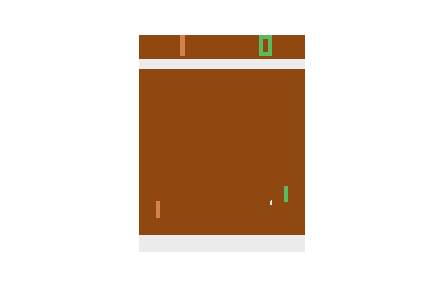
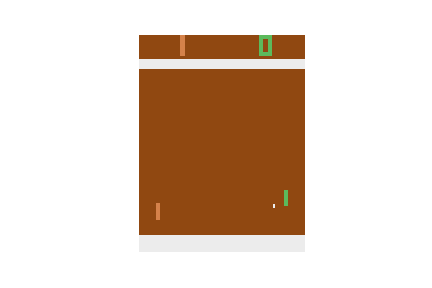
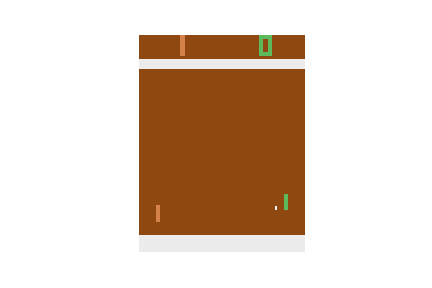
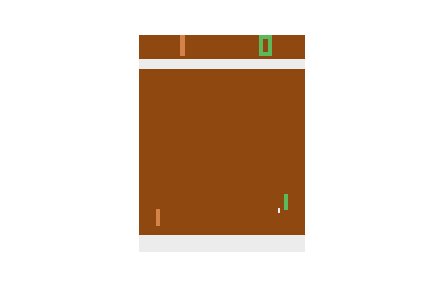
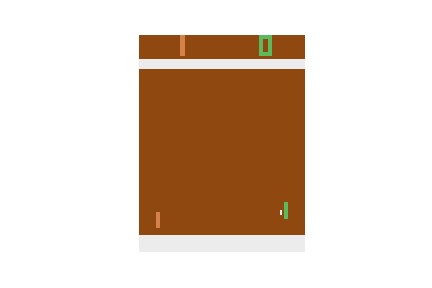
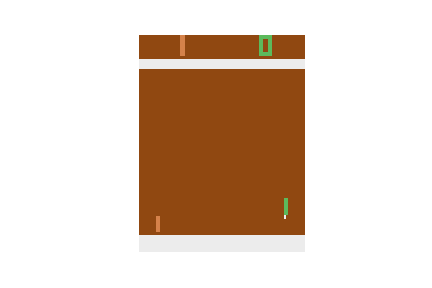
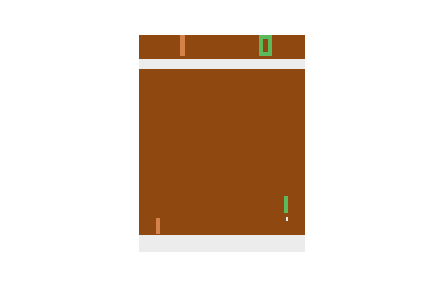
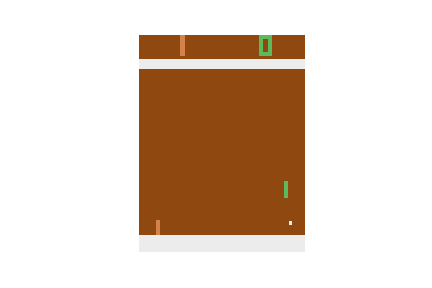
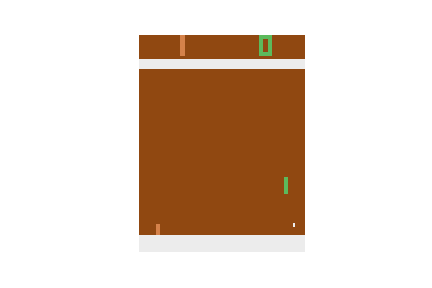
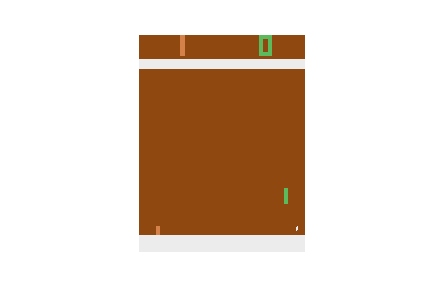
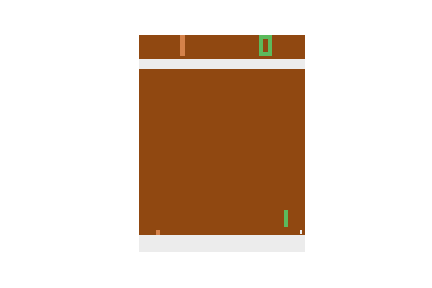
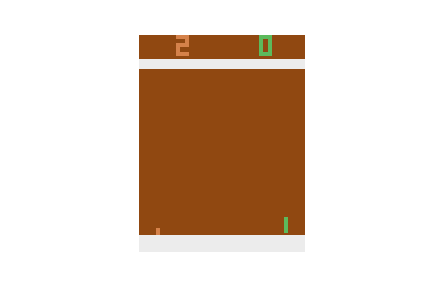
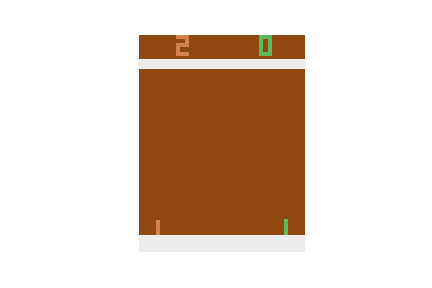
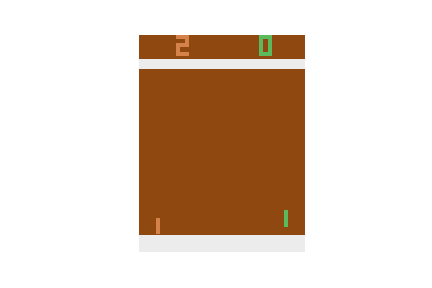
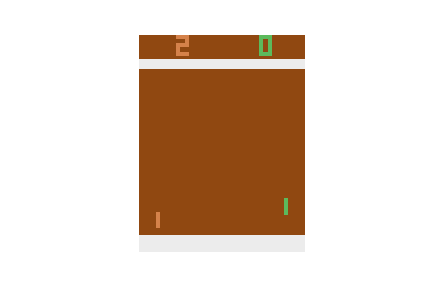
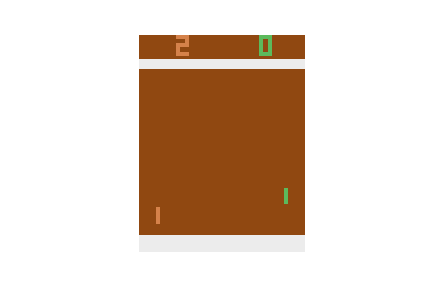
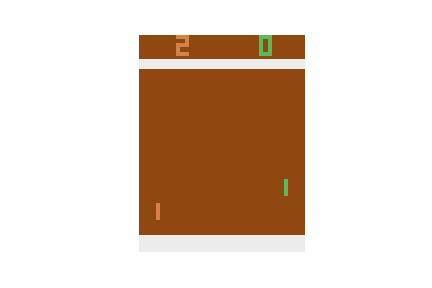
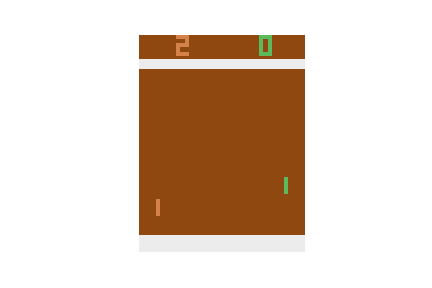
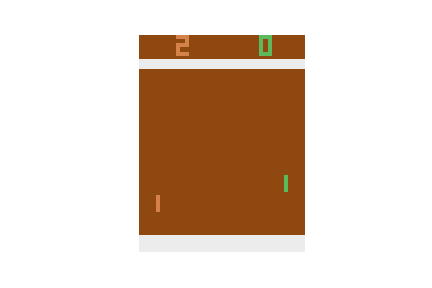
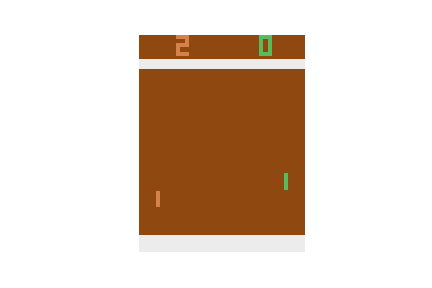
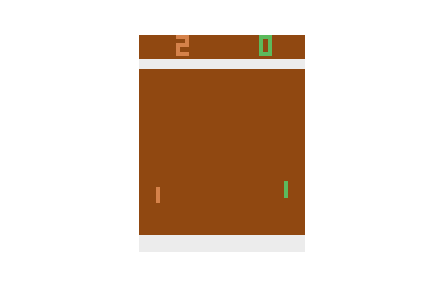
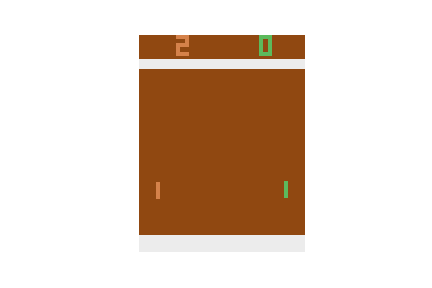
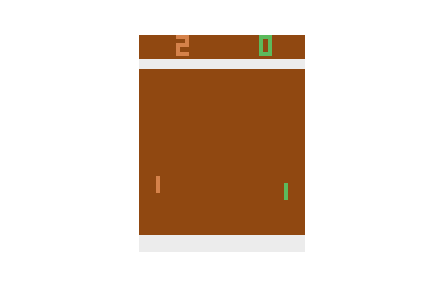
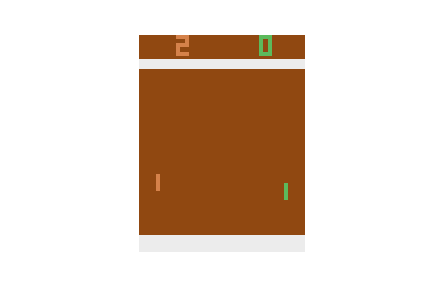
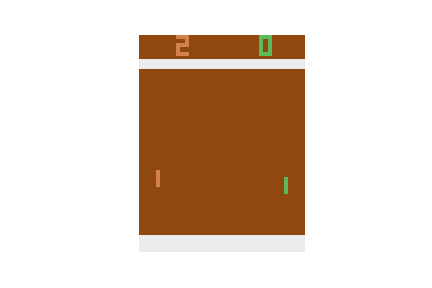
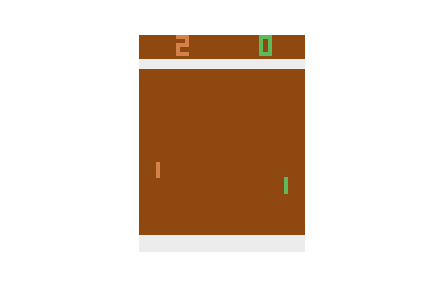
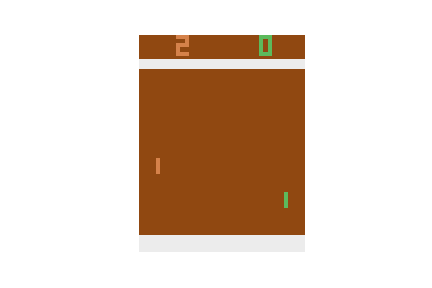
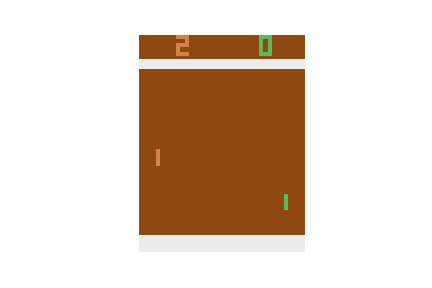
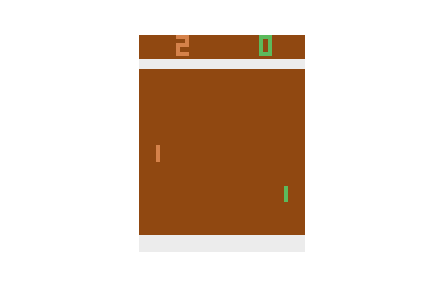
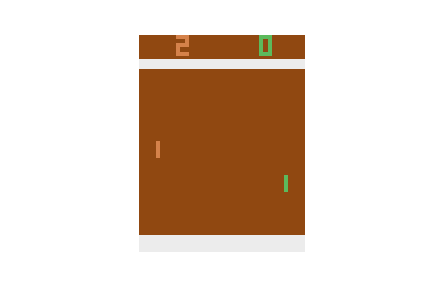
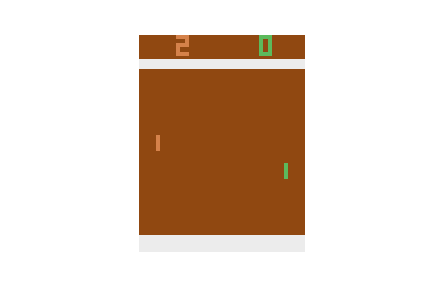
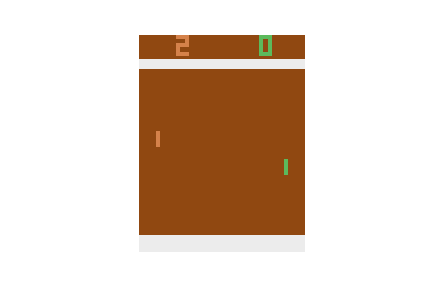
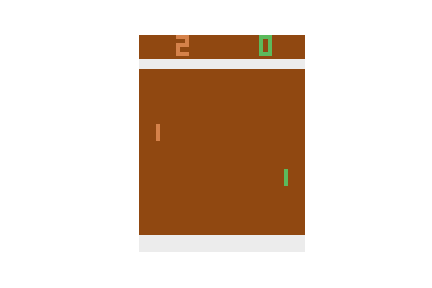
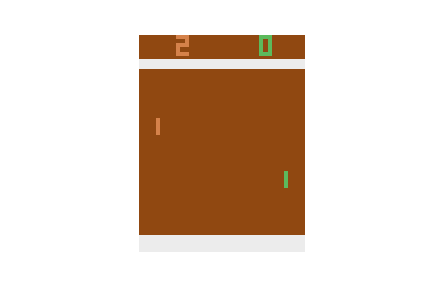
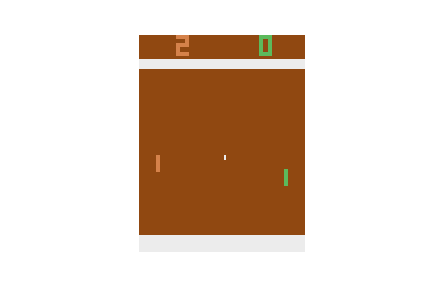
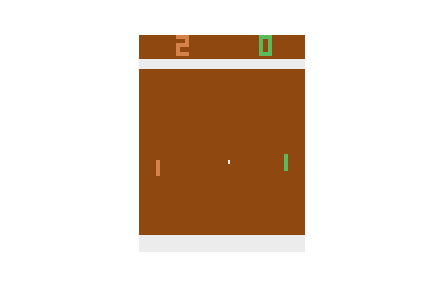
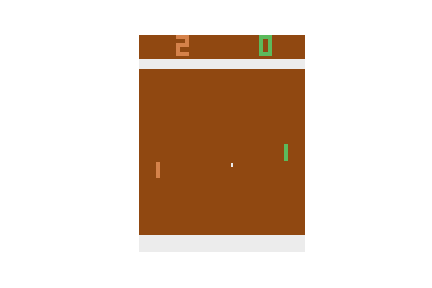
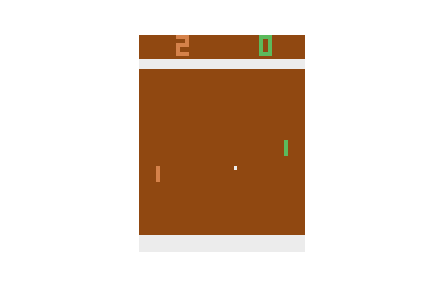
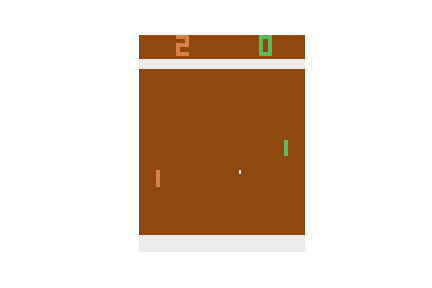
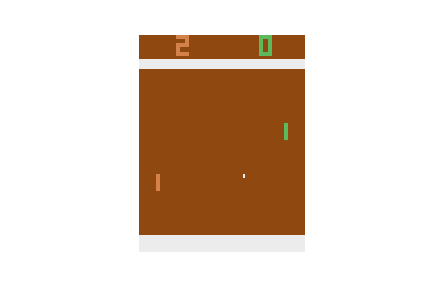
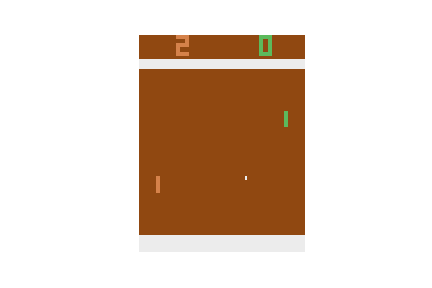
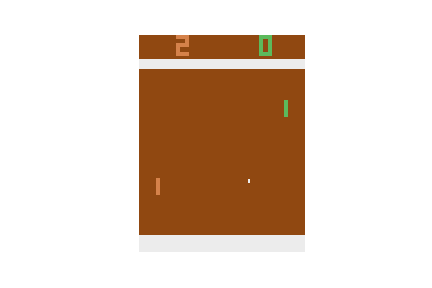
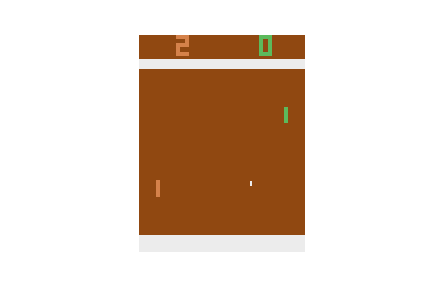
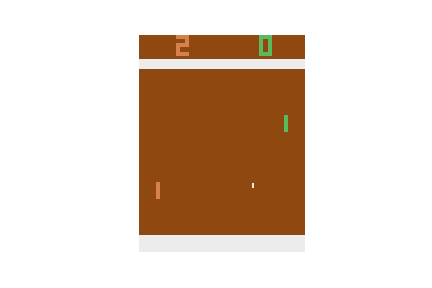
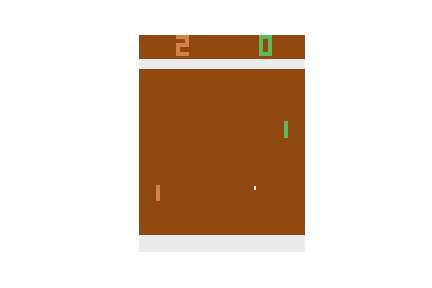
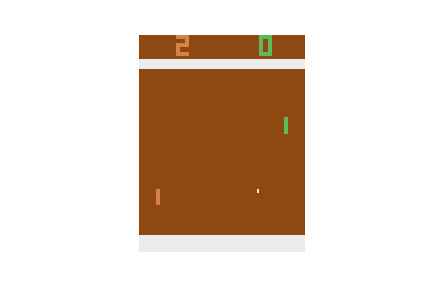
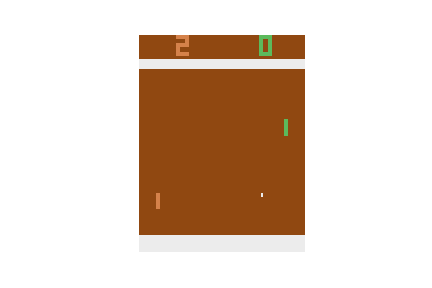
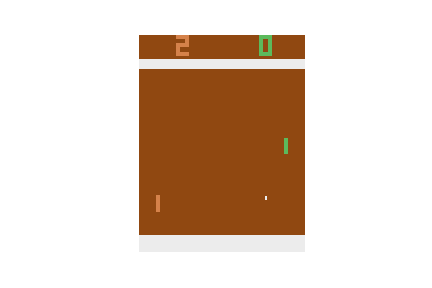
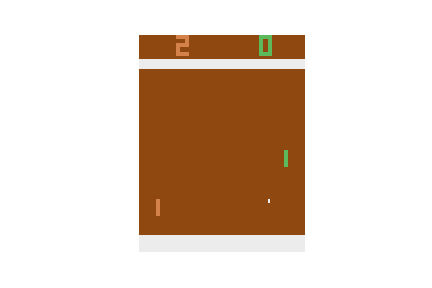
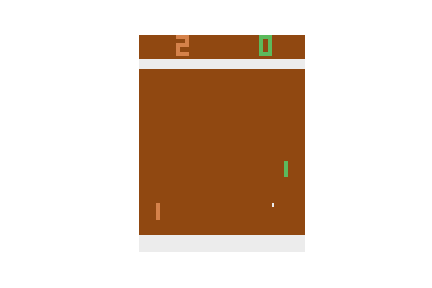
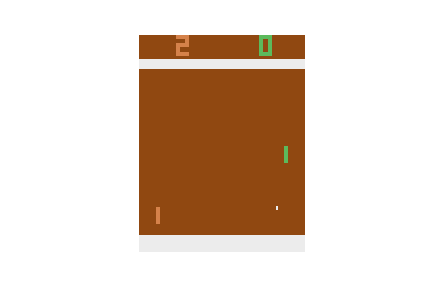
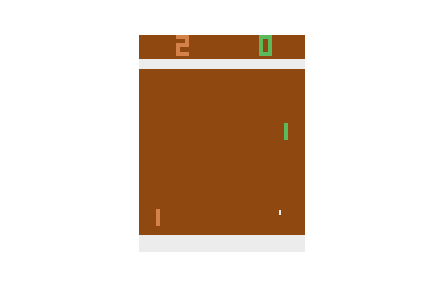
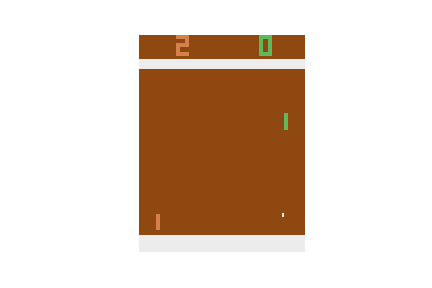
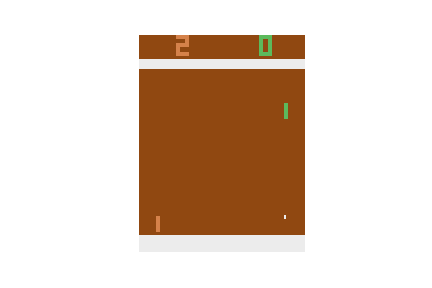
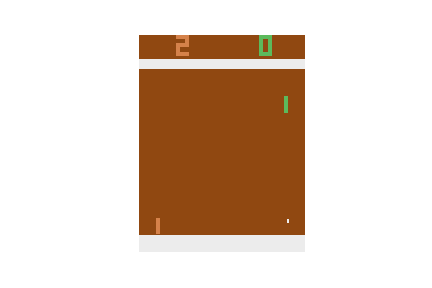
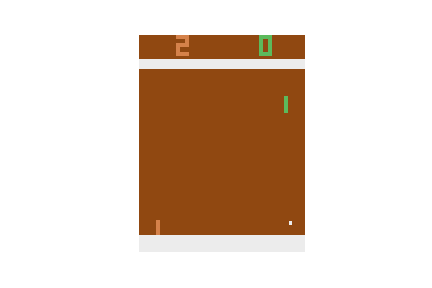
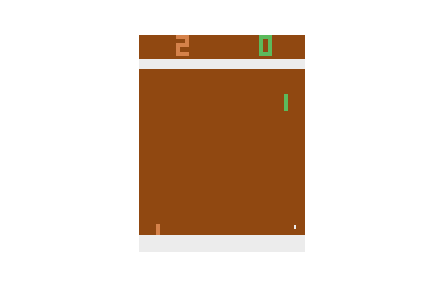
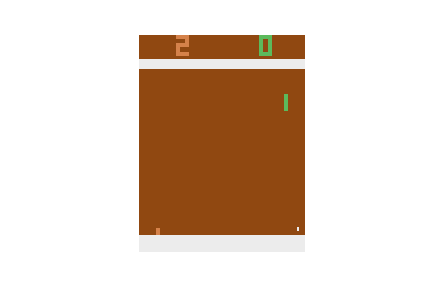
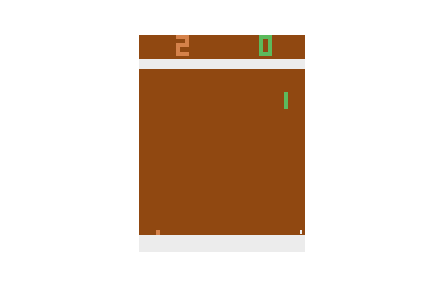
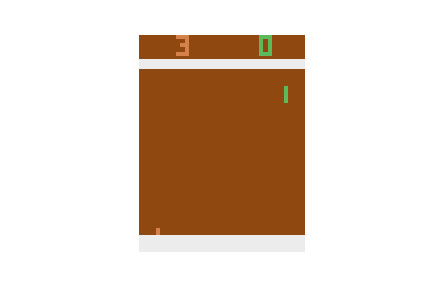
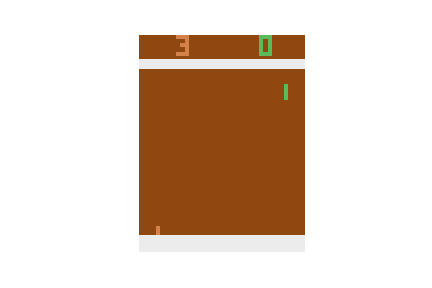
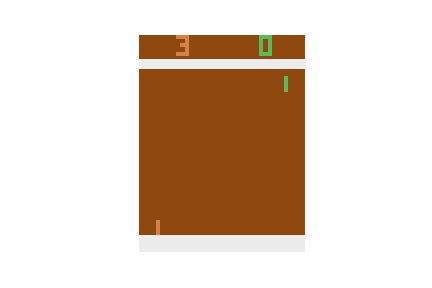
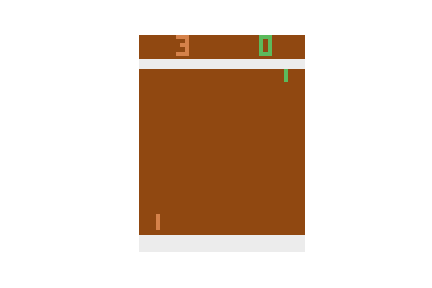
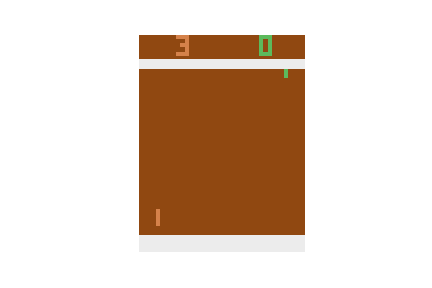
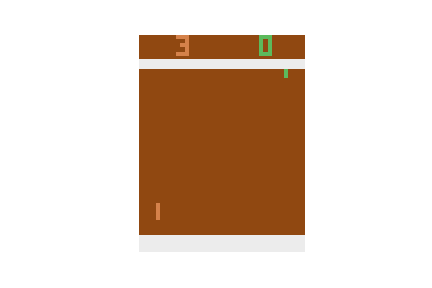
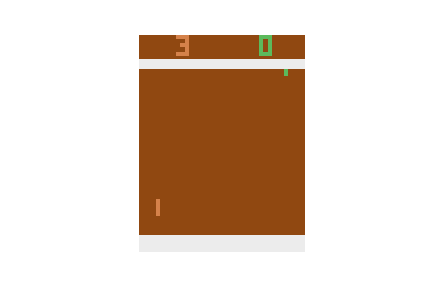
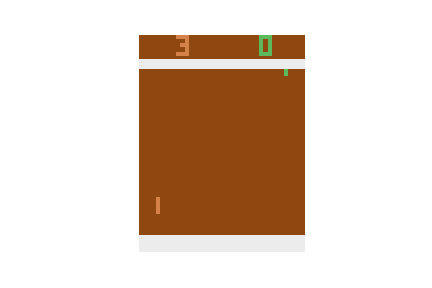
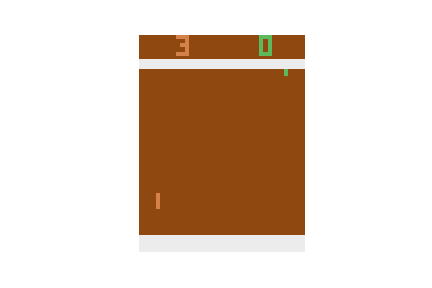
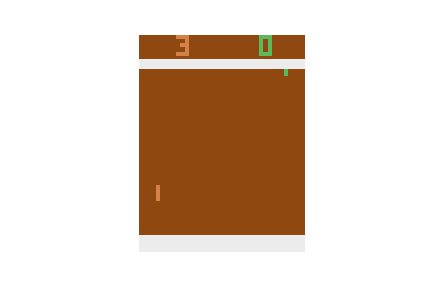
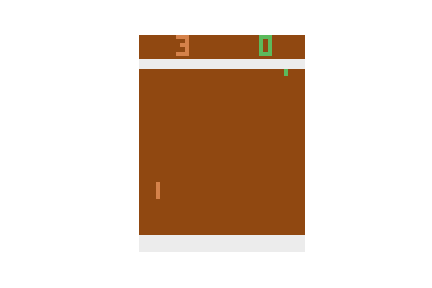
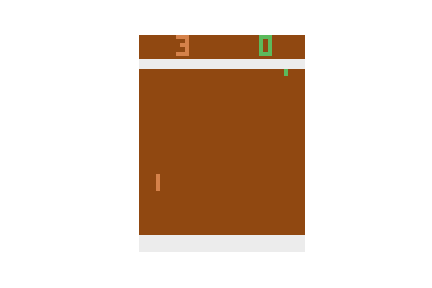
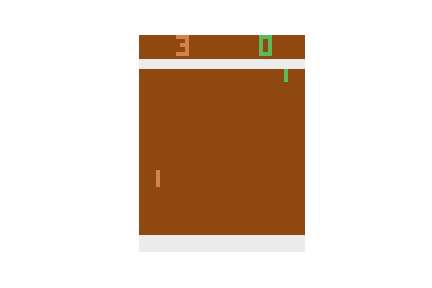
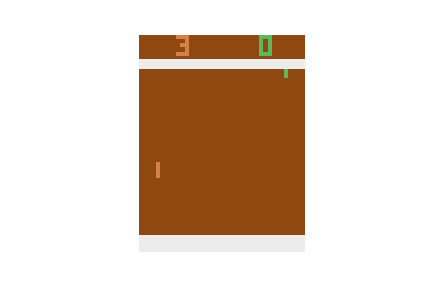
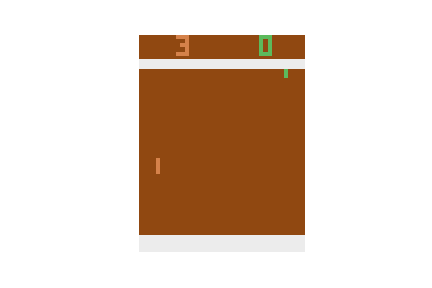

In [9]:
import gym 
env = gym.make("Pong-v0")

from src import draw 
%matplotlib inline
draw.display_frames(draw.generate_frames(env, 200))

In this video, the agent is in green. Once the agent decides which way to move the paddle, the game simulator executes the chosen action and updates the image on the screen. It also gives the agent a reward: +1 if the ball went past the opponent, -1 if the ball goes past the agent, and 0 otherwise. 

More formally, the game consists of a sequence of images (210x160x3 arrays containing integers from 0 to 255), $S^t$, and actions (moving the paddle UP or DOWN), $A^t$, both of which we model as random variables (hence the capital letters):

\begin{equation}
S^0 \xrightarrow[A^0]{} S^1 \xrightarrow[A^1]{} \mbox{ } \cdots 
\end{equation}

Associated with each realization of a state-action pair $(s, a)$ is a reward $R(s,a) \in \{-1, 0, +1\}$. The goal is to find the policy $\pi(a\,|\,s)$, representing the probability of choosing action $a$ in the state $s$, that maximizes the expected value of a cumulative reward over all time steps. 

What the cumulative reward should actually be is open to debate. For example, the pong game simulator assigns a reward of 0 when the agent's paddle hits the ball, even if the result is to launch the ball on a trajectory that evades the opponents paddle. Arguably, then, a positive (not zero) reward should be assigned to the agent's volley. This ambiguity in how to assign credit is widespread in RL problems and is known as the *credit assignment problem*. 

In the Pong game, a trajectory (or episode) is defined to be the time course up to the point at which the first player wins 21 games. We define the cumulative reward associated with a trajectory to be 

\begin{equation} 
R_{tot} = \sum_{games: i} \left(\gamma^{T_i}  + \gamma^{T_i-1} + \cdots + \gamma + 1 \right) R^{\sum_{j=1}^i T_j}.
\end{equation}

where $T_i$ is the duration of game $i$, $\gamma<1$ is a discount factor, and $R^t = R(S^t, A^t)$ . In addition to assigning +1 when the ball goes past the opponent, for example, this formula assigns positive rewards to earlier timesteps in an exponentially decreasing manner. 



## Learning the optimal policy

There are two ways to learn the policy with greatest rewards. The first, Dynamic Programming, makes the strong assumption that the agent knows the environment before experiencing it. That is, given the current state and action, the future state can be computed (or learned). 

In the second approach, Policy Optimization (also called Direct Policy Search), the agent gains knowledge of the environment only through its experience of it. This amounts to taking completely random actions and measuring the rewards that they induce. One then gradually increases the frequency with which actions are taken that by chance turned out to be advantageous in certain environmental states. This process of blindly searching policy space and choosing directions that lead to better rewards is similar to natural selection, which randomly explores genotype space while selecting fitter individuals at the expense of those less fit. And just like natural selection leads to unexpected adaptations in biology, Policy Optimization often works surprisingly well (e.g. Cross Entropy Method). 

But can we do better by leveraging additional information about the reward, viewed as a function of states (and possibly actions)?  Policy Gradient Methods find optimal policies by making use of the gradient of the reward function with respect to the parameters of the policy function. 




## Policy Gradient

Parametrize the policy function $\pi(a \, | \, s)$ by a tensor of weights, $W$. Let the random variable $\tau$ denote a trajectory $\{S^0, A^0; \cdots ; S^T\}$. 
Since the gradient $\nabla_W E_\tau [R_{tot}]$ indicates the direction in $W$-space in which $E_\tau[R_{tot}]$ increases most rapidly, the iteration 

\begin{equation} 
W \leftarrow W + \eta \nabla_W E_\tau[R_{tot}]
\end{equation}

will converge to a set of parameters that define a locally optimal policy. A [clever algebraic manipulation](https://www.youtube.com/watch?v=yCqPMD6coO8&list=PLA89DCFA6ADACE599&index=20#t=23m) due to Williams allows us to write the update in terms of the gradient of the policy

\begin{equation} 
\nabla_W E_\tau[R_{tot}] = E_\tau\left[\, R_{tot} \sum_{t=0}^T \nabla_W \log \pi(A^t \, | \, S^t)\,\right].
\end{equation}

In practice we estimate the expectation by generating a small sample of trajectories and computing the sample mean. The variance in this estimator is proportional to the number of random variables involved ($T^2$), which can be reduced by a factor of two by a [clever algebraic trick](https://www.youtube.com/watch?v=oPGVsoBonLM#t=23m18s) to obtain: 

\begin{equation} 
\nabla_W E_\tau[R_{tot}] = E_\tau\left[\, \sum_{t=0}^T \nabla_W \log \pi(A^t \, | \, S^t) 
\sum_{t'=t}^T 
R_d^{t'} \,\right],
\end{equation}

where $R^{t}_d$ is the discounted reward we have chosen to assign to time step $t$. 

The expression on the right-hand side makes intuitive sense: it tells us that we should shift $W$ in the direction that increases the probability of actions $\left(\nabla_W \log \pi\right)$ that result in postive cumulative future discounted rewards $\left(\sum_{t'=t}^T 
R_d^{t'}\right)$. Andrej Karpathy discusses this in more detail in his [blog](http://karpathy.github.io/2016/05/31/rl/) in the section entitled "Deriving Policy Gradients". 




## Policy function

To compute a formula for the policy gradient, $\nabla_W \log\pi$, we need a model for the policy function $\pi(a \, | \, s)$. 
Since there are only two possible actions, the policy function can be specified by the probability of moving the paddle up, $p(s)$:

\begin{eqnarray} 
\pi(\uparrow | \, s) & = & p(s) \\
\pi(\downarrow | \, s) & = & 1 - p(s).
\end{eqnarray}

Following [Andrej Karpathy](http://karpathy.github.io/2016/05/31/rl/), we use a three-layer feedforward neural network to model $p(s)$ as a function of the image, $s$ [image credit: Andrej Karpathy]:

![Policy network used by Andrej Karpathy](images/karpathy_policy_network.png)

The layers of the neural network are connected via two weight matrices, $W^1$ and $W^2$ (no biases). 
## TO DO: picture of NN; label neurons and weights; label input, hidden, output layers







## Xavier Initialization 
To instantiate the neural network, we have to make choices for the initial values of the weights. We use Xavier normalization, a procedure that prevents neuron saturation and  slowdown of learning. (Michael Nielsen gives a nice discussion of Xavier normalization [here](http://neuralnetworksanddeeplearning.com/chap3.html#weight_initialization). The math can be found [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization).) 

In [ ]:
number_rows, number_columns = x.shape
input_dimensions = number_rows
num_hidden_layer_neurons = 200 
output_dimension = 1

weights = {
    1: np.random.randn(num_hidden_layer_neurons,input_dimensions) / np.sqrt(input_dimensions),
    2: np.random.randn(output_dimension, num_hidden_layer_neurons) / np.sqrt(num_hidden_layer_neurons)
}

## Forward propagation 

The process of computing $p(s)$ is referred to as forward propagating through the network. Unroll the set of pixels in the image into a vector $s_j$. Then the activations of the neurons in the hidden layer, $h_i$, is given by

\begin{equation} 
h = g(W^1s)
\end{equation} 

where $g(z)$ is the sigmoid function, and the activation of the output neuron is

\begin{equation} 
p = g(W^2h).
\end{equation} 




In [ ]:
import numpy as np 

def vectorize(image):
    image = image.astype(np.float).ravel() # flatten
    length, = image.shape
    return image.reshape(length,1) # return column vector

x = vectorize(state)

## Backward propagation 

Having set up a model for $p(s)$ we may now compute $\nabla_W \pi( a\, | \, s)$. Considering the two possible values of $a$ separately, and using the chain rule of differentiation, one may show that the gradient of the policy with respect to the hidden-output weights is

\begin{equation} 
\nabla_{W^2} \pi( a\, | \, s) = \delta^3(s,a) h(s) 
\end{equation} 

where

\begin{eqnarray} 
\delta^3(s,a) & = & y(a) - p(s) \\
y(a) & = & 
\left\{ 
\begin{array}{cc} 
1 & \text{if } a = \uparrow\\
0 & \text{if } a = \downarrow
\end{array}
\right.
\end{eqnarray} 

## TO DO: interpret delta^3


Though the dynamics of the Atari environment is determinisitic, the fact that the agent does not know everything about the environment effectively makes the dynamics stochastic. For example, given ball location, ball velocity, the way we move the paddle, etc, the Atari simulator computes with certainty the next state of the system. However the agent is provided only with a static screenshot that lacks information about the balls velocity, for example; thus the agent can only guess where the ball will be in the next screenshot. 

We can remove some of that stochasticity by providing the agent with the difference of successive screen shots, which codifies both ball position and velocity. 

In [ ]:
def process(image):
    """ convert the 210x160x3 uint8 frame into a 80 x 80 matrix"""
    image = image[35:195] # crop
    image = image[::2, ::2, :] # downsample
    image = image[:, :, 0] # remove_color
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return image

state = process(state)
plt.imshow(state)

In [ ]:
def sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z)) 

In [ ]:
def forward_propagate(x):
    h = sigmoid(np.dot(weights[1], x))
    p = sigmoid(np.dot(weights[2], h))
    return float(p), h # return probability of taking action 2, and hidden state

In [ ]:
state = env.reset()
def policy(state, action): 
    p, h = forward_propagate(vectorize(process(state)))
    return p if action == 'up' else (1-p)
policy(state,'up') + policy(state, 'down')

In [ ]:
state = env.reset()
def step(state):
    state, reward, done, info = env.step(action)
    return state

In [ ]:
step(state)

In [ ]:
while True:
    env.render()
    policy(state,action)
    action = choose_action(p)
    actions.append(action)
    state, reward, done, info = env.step(action)
    rewards.append(reward)


In [ ]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import cPickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(xrange(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
env_step = 0
while True:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)
    
    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    grad = policy_backward(eph, epdlogp)
    break

    for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.iteritems():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    print 'resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward)
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
    print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

